### Сегментация легких ###

### Анамнез ###
1. В целом легкие представляют из себя два связных темных пятна на снимках
2. Тем не менее, на ряде изображений этот критерий существенно нарушается: иногда сердце мимет практически такую же проницеамость и отличимо лишь по контурам; иногда в легкие вдаются костные выросты (грдина? искривленный позвоночник), которые на метках исключены. В то же время, например, ключицы входят в облатсь легких, т.к. находятся "перед" ними. Поэтому полагатся только на интенсивность нельзя.
3. Изображений достаточно много, чтобы, с учетом аугментаций, натренировать небольшую сеть.

### Архитектура сети ###

Нейросетевая часть очень похожа на задание 1. Все так же UNet4, по сути, единственный вариант, доступный по вычислительной мощности и способности обучаться на малом наборе данных. 

Для тренировки из изображения вырезается случайный кусок от 0.8 до 1.0 площади исходного изображения, и маштабируется до 128*128. Это несколько насыщает тренировочные данные, не изменяя их типичных особенностей. Например, нерезка на малые куски или отржения наверняка лишь ухудшили бы результат, так как распределение валидационных данных обладало бы общими особенностями (e.g. сердце слева), поторыми не обладал бы тренировочный датасет.

Я тренировал сеть при помощи `Adam`, `lr=0.01`, коэффициент затухания `lr=0.9999`, 1 эпоха == длине тренировочного датасета (52 шт), батч = 4 избражения. Результаты проверялись после 100 и 300 эпох тренировки. 300 эпох занимает на моей машине ~45 минут.

### Метрики ###
На мой взгляд, для масок крупных объектов хорошей метрикой для бинарной сегментации является IOU: ее высокие значения обеспечивают, что маски "геометрически" близки. При этом, например, ошибка в виде тонкой линии (которую впоследствии легко исправить пост-процессингом, как в первом задании), внесет существенно меньший вклад, чем круглое пятно (которое, например, на границе областей устаранить непросто). Это отвечает геометрической интуиции понятия "хорошего решения".

Также я вычисляю попиксельный F1_score в основном потому, что он остался у меня от первой задачи.и его легко считать. Для бинарной классификации есть и более аккуратные метрики, например коэффициент Мэтьюса. На сколько мне известно, F1 ведет себя *принципиально неадекватно* в случае существенного дисбаланса классов. На картинках, где легкие занимают примерно 1/3 площади и она должна вполне хорошо выражать успешность того или иного алгоритма. Опять же, время не резиновое и часть углов приходится срезать. На практике метрику все равно пришлось бы выбирать прагматически, исходя из имеющиейся задачи. Например, если важна мажоранта области, нужно с большим весом учитывать ложно отрицательные пиксели, если минранта -- то ложно положительные и т.д.
Опять, же достаточно хорошими геометрическими инвариантами являются площадь и периметр.

In [1]:
import data2
import modeltools2
import os
from unet import UNet
import torch, torch.utils, torch.utils.data
from torchsummary import summary
import modeltools1
import datetime
import torchvision
import sklearn, sklearn.metrics
import numpy as np
from tqdm.notebook import tqdm

data_dir = "../02_image_segmentation2/xray-lung-segmentation"
train_file = "idx-trn0.txt"
val_file = "idx-val0.txt"

out_dir = "out2"
if not os.path.exists(out_dir): os.mkdir(out_dir)
device = torch.device("cuda")

weights_path = None

# comment all lines beow to train the UNet from scratch
# weights after 300 epochs of training
weights_path = "lungs_weights300.dat"

# weights after 100 epochs of training
# weights_path = "lungs_weights100.dat"


In [2]:
train_dataset = data2.LungsDataset(data_dir, train_file)
val_dataset = data2.LungsDataset(data_dir, val_file)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size = 4, num_workers=2, 
    pin_memory=True)

val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size = 4, num_workers=2, 
    pin_memory=True)

# train_dataset[0]

In [3]:
model = UNet(in_channels = 1, out_channels=2, n_blocks = 4).to(device)
summary(model, (1, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             320
              ReLU-2         [-1, 32, 128, 128]               0
       BatchNorm2d-3         [-1, 32, 128, 128]              64
            Conv2d-4         [-1, 32, 128, 128]           9,248
              ReLU-5         [-1, 32, 128, 128]               0
       BatchNorm2d-6         [-1, 32, 128, 128]              64
         MaxPool2d-7           [-1, 32, 64, 64]               0
         DownBlock-8  [[-1, 32, 64, 64], [-1, 32, 128, 128]]               0
            Conv2d-9           [-1, 64, 64, 64]          18,496
             ReLU-10           [-1, 64, 64, 64]               0
      BatchNorm2d-11           [-1, 64, 64, 64]             128
           Conv2d-12           [-1, 64, 64, 64]          36,928
             ReLU-13           [-1, 64, 64, 64]               0
      BatchNorm2d-14      

In [4]:
lr = 0.01
optim_params = model.parameters()
optim = torch.optim.Adam(optim_params, lr=lr)
# loss = torch.nn.CrossEntropyLoss()
loss = modeltools1.FocalLoss(reduction="mean")
scheduler = torch.optim.lr_scheduler.ExponentialLR(optim, gamma =0.9999)
epochs = 10 #optimal value is 100

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0, batch 52, loss: 0.06828171014785767, lr: [0.009947137566032547]
Epoch 1, batch 52, loss: 0.05588827282190323, lr: [0.009894554575757594]
Epoch 2, batch 52, loss: 0.04341818764805794, lr: [0.009842249551967755]
Epoch 3, batch 52, loss: 0.023056985810399055, lr: [0.009790221025264544]
Epoch 4, batch 52, loss: 0.021275952458381653, lr: [0.00973846753401706]
Epoch 5, batch 52, loss: 0.017449628561735153, lr: [0.00968698762432094]
Epoch 6, batch 52, loss: 0.018327899277210236, lr: [0.009635779849957513]
Epoch 7, batch 52, loss: 0.020231978967785835, lr: [0.00958484277235318]
Epoch 8, batch 52, loss: 0.015873288735747337, lr: [0.009534174960538981]
Epoch 9, batch 52, loss: 0.014763027429580688, lr: [0.009483774991110418]


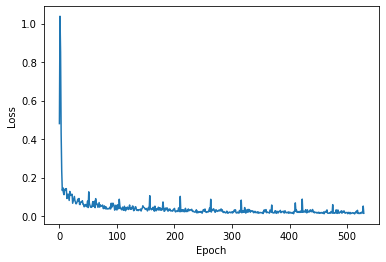

In [5]:
losses = []
if ("weights_path" in locals() or "weights_path" in globals()) and weights_path:
    model.load_state_dict(torch.load(weights_path))
else:
        train_dataset.train()
        model.train()
        modeltools1.train_model(model, loss, optim, scheduler, train_dataloader,
                num_epochs = epochs, device = device) 
        model.cpu()
        current_time = datetime.datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
        torch.save(model.state_dict(), './lungs_weights'+current_time+".dat")

Ниже сетка прогоняется на тренировочном и валидационных датасетах. В папке out2 сохранаются исходное изображение (для наглядности), предсказанная маска и исходная метка.

In [6]:
model.eval()
model.to(device)
train_dataset.eval()
val_dataset.eval()
F1_score, IOU_score = modeltools2.eval_model_on_dataloader(model, train_dataloader, device, "out2/img")
print(f"train F1 score {F1_score}, IOU score: {IOU_score}")   
F1_score, IOU_score = modeltools2.eval_model_on_dataloader(model, val_dataloader, device, "out2/img")
print(f"val F1 score {F1_score}, IOU score: {IOU_score}")   

Validation:   0%|          | 0/53 [00:00<?, ?it/s]

train F1 score 0.9431135360231097, IOU score: 0.893511507871016


Validation:   0%|          | 0/36 [00:00<?, ?it/s]

val F1 score 0.9399836691081003, IOU score: 0.8892735156794669


### Результаты ###    
    
    Эпох    | F1 train  | IOU train | F1 val    | IOU val  | Loss
    10      | 0.844359  | 0.7507    | 0.820202  | 0.723840 | 0.0147
    100     | 0.968350  | 0.938900  | 0.956945  | 0.923821 | 0.0075
    300     | 0.9749    | 0.9511    | 0.9585    | 0.9266   | 0.0037

Глазометрическое изучение результатов показло, что разница между предсказаниями сетки после 100 и 300 эпох тренировки мало сущетвенна. Из плюсов, это говорит в пользу адекватности наших метрик, они тоже изменились несильно. Из минусов, надежда, что ту же сеть можно натренировать на тех же данных лучше, слабая. Ниже привожу несколько примеров работы сетки (300 эпох) на валидационном датасете.

Зеленым отмечен пример незначительной ошибки, которые элементарно устраняются пост-процессингом. Красным -- ошибки, которые устранить сложнее. В основном они возникают на снимках с уникальными анатомическими особенностями: сетке просто не хватило таких данных в трен-датасете. Ну и одно изображение просто супер неконтрастное, а я не делаю никакой входной коррекции, равно как и соответствующих аугментаций. Результат кажется мне достаточно хорошим.
![](lungs_demo1.png)

### Эвристический алгоритм ###

На моей машине инференс проходит со скоростью 8 снимков в секунду вместе с подсчетом метрик и сохранением файлов и в целом сеть дает хороший результат, но эту задачу можно решать и прямым алгоритмом. Это дает больший контроль над морфологией объекта, поэтому в некоторых случах может быть предпочтительным. 

Я попробовал скормить эти картинки ванильному MSER (в реализации opencv 4.5.5), но выявилось несколько проблем: а) он сильно зависит от контрастности изображения. С этим можно было бороться посредством какого-то варианта автоматической гамма-коррекции. Что гораздо хуже, в силу своей природы, MSER объединяет области в объекты несколькими способами. Так, например, появляются объекты класса легкое+сердце, легкое, легкое без куска и придумать простой алгоритм различения "правильного варианта" мне не удалось. Более того, не видя исходного снимка, я бы и сам не взялся сделать такой выбор. Вот пример объектов, которые MSER находит на одном и том же изоражении. Кроме первого, это все вариации левого легкого.
![](lungs_demo2.png)

В то же время, более примитивный метод Отсу, который по сути являается статистически аккуратным способом выбрать бинарную границу освещенности объектов перднего плана по крайней мере дает достаточно стабильный результат. Единственно, что на ряде изображений он срабатыват на черный фон вокруг снимка, но это легко исправить.